201 201 201


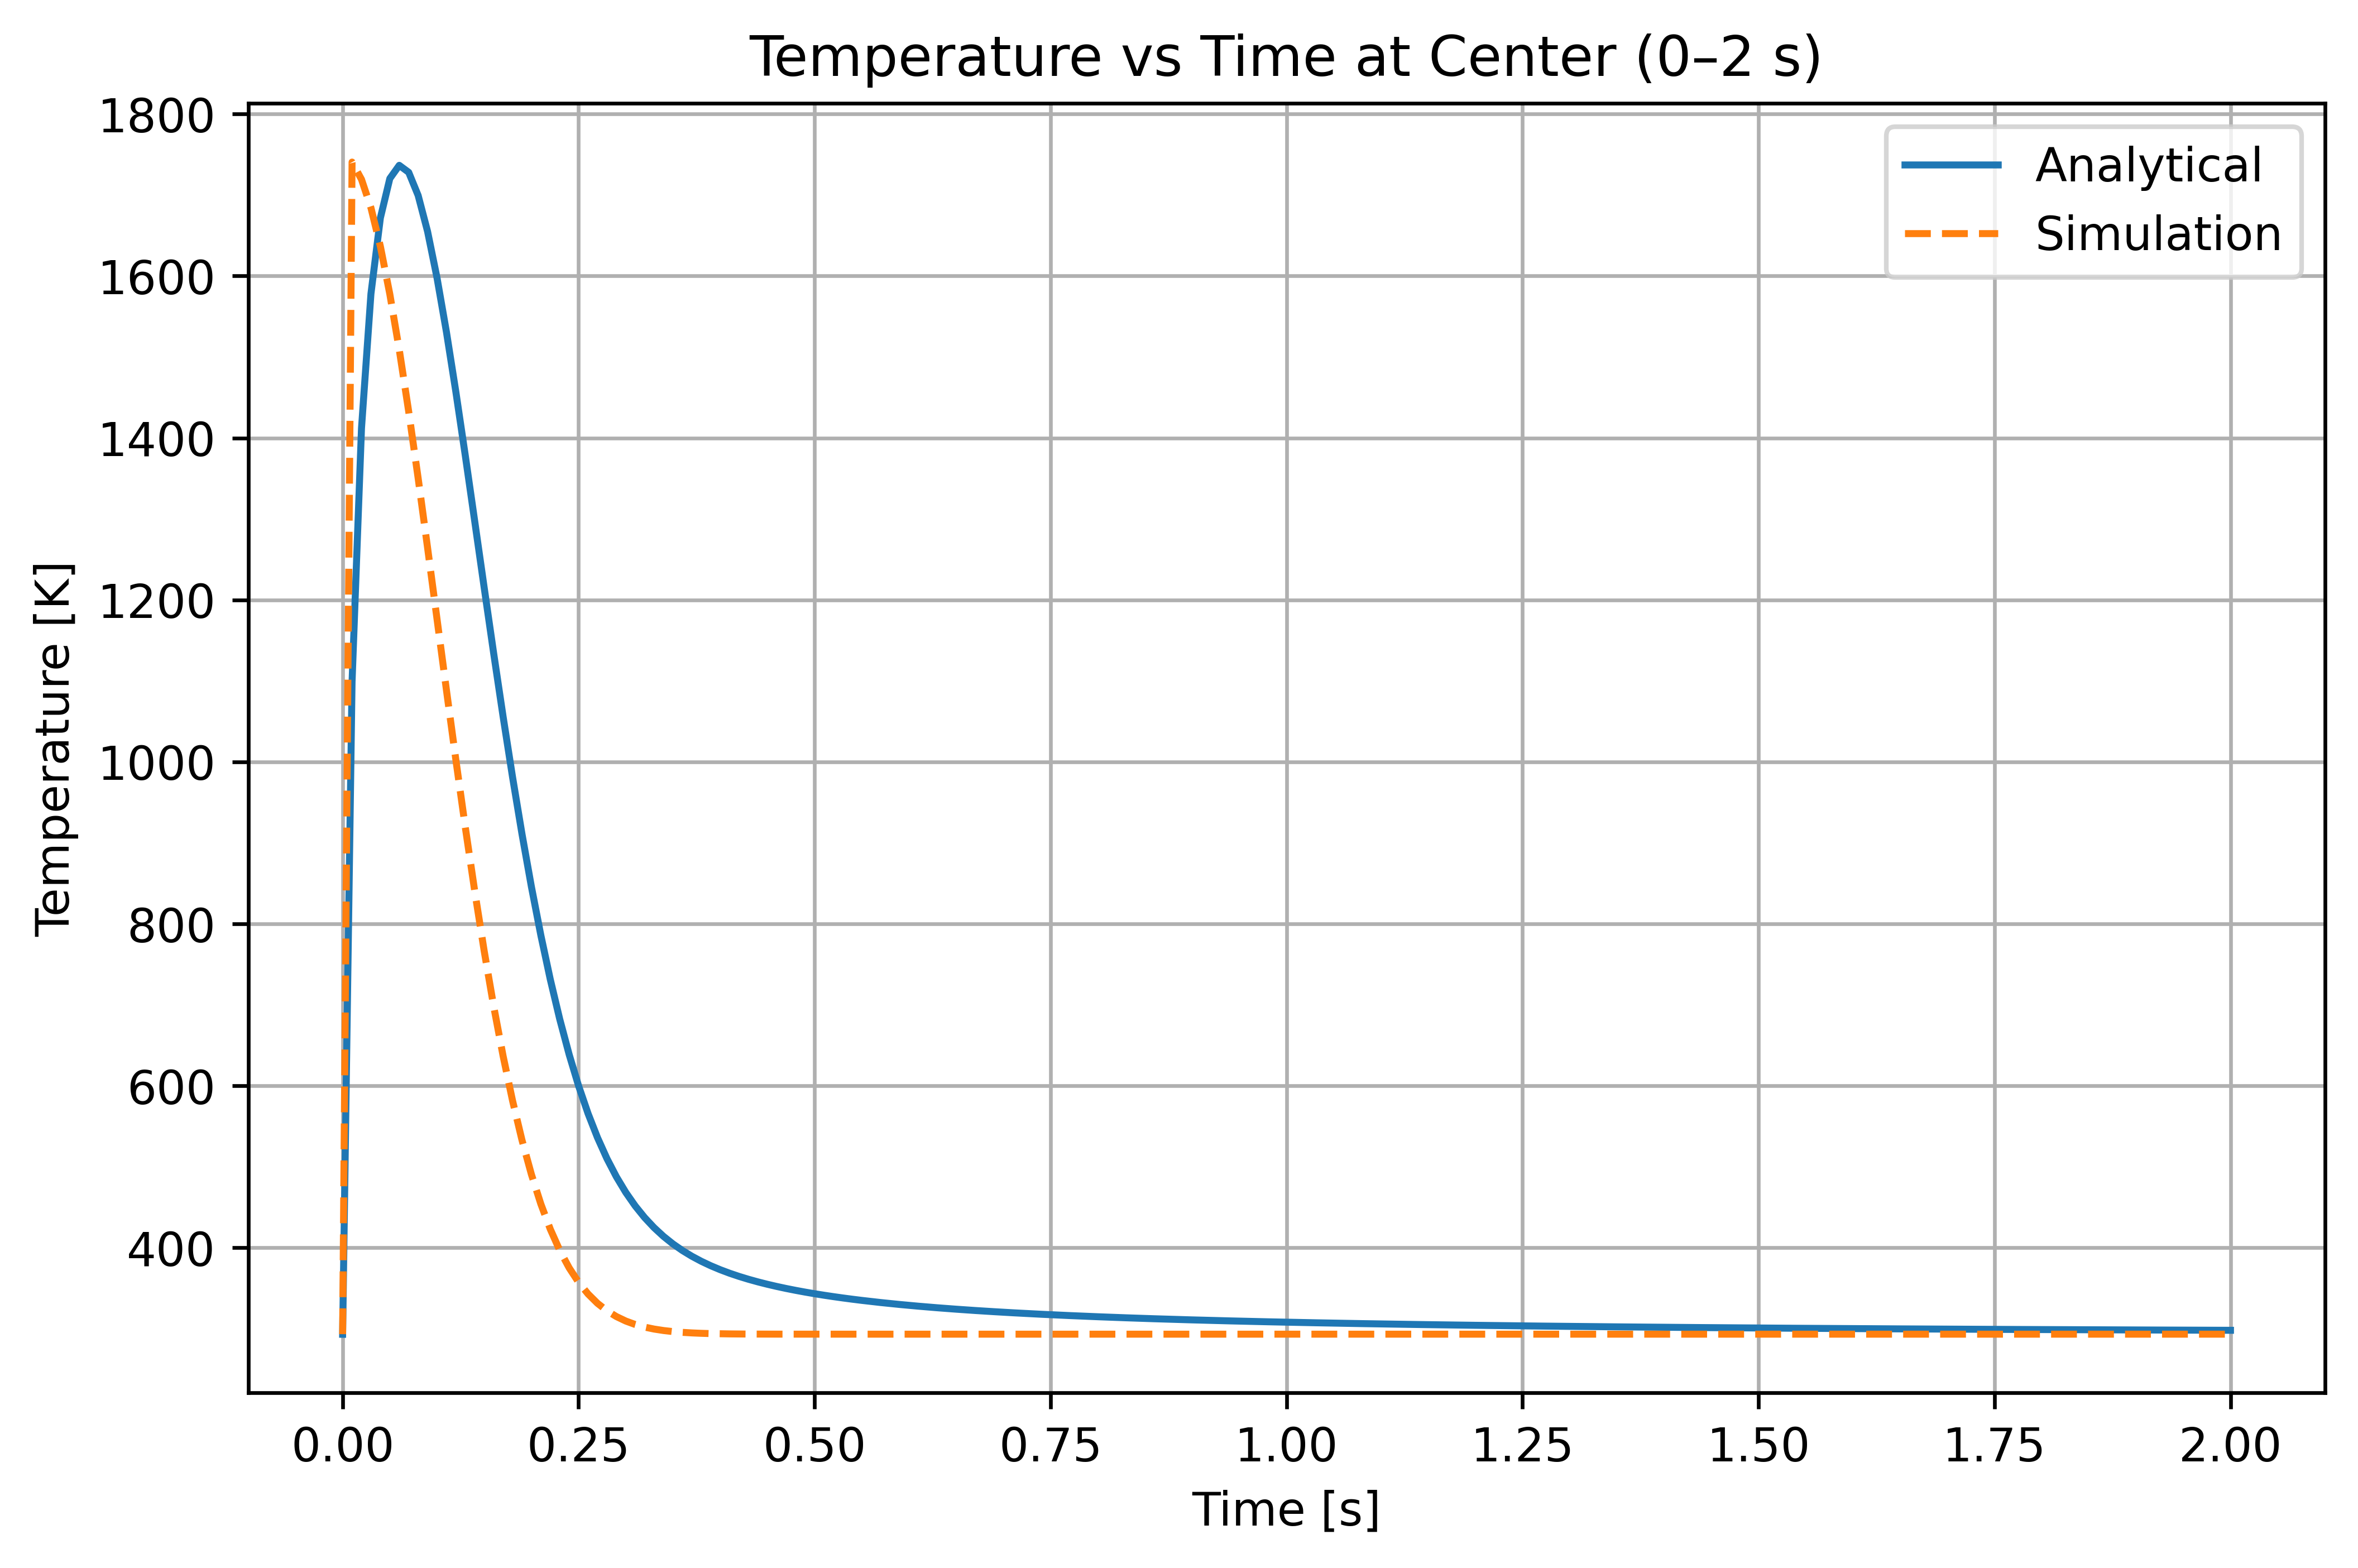

Peak error: 0.23%
RMSE after 0.005 s: 136.92 K
RMSE: 136.58 K
Mean Absolute Error (MAE): 66.53 K
Analytical peak at t = 0.060 s
Simulation peak at t = 0.010 s
Peak value of simulation: 1740.7013491747607 K
Peak value of analytical solution : 1736.6736081229014 K


In [2]:

"""
Analytical vs. Computational Temperature Comparison

This script calculates the analytical temperature response at the 
center of a material under a pulsed laser and compares it to 
computational simulation data.

Key Steps:
1. Define material and laser parameters:
   - rho, c, alpha → material density, specific heat, and thermal diffusivity
   - Laser properties: P, beam radius w, wavelength lambda_, pulse duration sigma
   - Optical absorption k_opt → penetration depth delta
   - Ambient temperature T0

2. Set up spatial grid (cylindrical coordinates):
   - Effective domain size smaller than computational domain to match max temperature
   - Nr x Nz points in r and z, create 2D meshgrid (R, Z)

3. Set up time grid:
   - Time steps from 0 to t_end with increment dt

4. Compute laser source term:
   - Normalize laser intensity I0
   - Compute spatial distribution (Gaussian in r, exponential in z)
   - Scale source term to temperature units using material properties

5. Compute analytical temperature at the center:
   - Loop over time steps:
       - Compute time differences from previous steps
       - Compute 3D Green's function
       - Multiply by spatial source and time-dependent laser pulse
       - Integrate over space and time for cumulative temperature
   - Add ambient temperature T0

6. Load and preprocess simulation data:
   - Read simulation temperatures from file
   - Truncate and interpolate simulation data onto analytical time grid

7. Compute error metrics:
   - Peak error (% difference between maxima)
   - RMSE and MAE for full time and after t > 0.005 s
   - Peak times for analytical and simulation data

8. Plot results:
   - Temperature vs. time for analytical and simulation
   - Save figures as PNG (and optionally PDF)
   - Provides visual validation of computational model

Notes:
- The analytical solution assumes an infinite 3D domain. To compare with a finite computational domain, 
  a smaller effective domain is used (0.004 m vs. 0.01 m), which aligns peak magnitudes but preserves 
  the temporal trend.
- Metrics and plots allow quantitative and qualitative assessment of simulation accuracy.

Dependencies:
- numpy
- matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt

# %% Material & Laser Properties
rho = 2700           # kg/m^3
c = 897              # J/(kg*K)
alpha = 237 / (rho * c)  # thermal diffusivity [m^2/s]

P = 0.5              # Laser power [W]
w = 0.001            # Beam radius [m]
lambda_ = 500e-9     # Wavelength [m]
k_opt = 8.4          # Optical absorption coefficient
mu_a = 4 * np.pi * k_opt / lambda_
delta = 1 / mu_a     # Penetration depth [m]
sigma = 0.1          # Pulse duration [s]
T0 = 293             # Ambient temperature [K]

# %% Spatial grid (cylindrical)
Rmax = 0.004
Zmax = 0.004
Nr = 40
Nz = 40

dr = Rmax / Nr
dz = Zmax / Nz
r = np.linspace(dr/2, Rmax - dr/2, Nr)
z = np.linspace(0, Zmax, Nz)

# Create 2D grid for vectorized computation
R, Z = np.meshgrid(r, z, indexing='ij')  # shape (Nr, Nz)

# %% Time grid
t_end = 2
dt = 0.01
time = np.arange(0, t_end + dt, dt)

# %% Normalize laser intensity
I0 = P / (np.pi * w**2)

# %% Precompute source term independent of t_diff
source_prefactor = (mu_a / (rho * c)) * I0
source_spatial = np.exp(-R**2 / w**2) * np.exp(-Z / delta) * 2 * np.pi * R * dr * dz  # shape (Nr, Nz)

# %% Preallocate temperature at center
T_center = np.zeros(len(time))
T_center[0] = T0

# %% Vectorized Green's function convolution
for n, t in enumerate(time[1:], start=1):
    # Previous times
    tp = time[:n]
    dtp = dt
    t_diff = t - tp  # array of shape (n,)

    # Avoid division by zero
    t_diff[t_diff <= 0] = 1e-12

    # Compute Green's function for each t_diff
    G = (4 * np.pi * alpha * t_diff[:, None, None])**(-1.5) * \
        np.exp(-(R**2 + Z**2)[None, :, :] / (4 * alpha * t_diff[:, None, None]))  # shape (n, Nr, Nz)

    # Source term in time
    source_time = np.exp(-tp**2 / (2 * sigma**2))[:, None, None]  # shape (n, 1, 1)

    # Accumulate temperature contribution
    T = np.sum(source_prefactor * source_spatial[None, :, :] * G * source_time * dtp)
    
    # Add ambient
    T_center[n] = T + T0

# %% Load simulation data if needed
data = np.loadtxt('temperature_vs_time.txt', skiprows=1)
time_fn = data[:, 0]
temp_fn = data[:, 1]
# Make sure both arrays have the same length
n = min(len(T_center), len(temp_fn))
T_center_trimmed = T_center[:n]
temp_fn_trimmed = temp_fn[:n]
time_fn_trimmed = time_fn[:n]  # optional, for plotting
time_trimmed = time[:n]


# Interpolate simulation onto analytical time grid
# Step 1: Truncate simulation data to t <= 2 s
mask = time_fn <= 2
time_fn_trunc = time_fn[mask]
temp_fn_trunc = temp_fn[mask]

# Step 2: Interpolate truncated simulation onto analytical time grid
temp_fn_interp = np.interp(time, time_fn_trunc, temp_fn_trunc)

# Now all arrays have the same length and the simulation ends at t = 2 s
print(len(time), len(T_center), len(temp_fn_interp))  # all should match

# Step 3: Plot
plt.figure(figsize=(8,5), dpi = 600)
plt.plot(time, T_center, linewidth=1.5, label='Analytical')
plt.plot(time, temp_fn_interp, '--', linewidth=1.5, label='Simulation')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Temperature vs Time at Center (0–2 s)')
plt.legend()
plt.grid(True)
plt.savefig('Analytical_vs_simulation.png')
plt.show()



import numpy as np

# Step 1: Truncate simulation data to t <= 2 s
mask_trunc = time_fn <= 2
time_fn_trunc = time_fn[mask_trunc]
temp_fn_trunc = temp_fn[mask_trunc]

# Step 2: Interpolate truncated simulation onto analytical time grid
temp_fn_interp = np.interp(time, time_fn_trunc, temp_fn_trunc)

# Step 3: Assign trimmed arrays for clarity
time_trimmed = time          # analytical time grid already 0->2 s
T_center_trimmed = T_center  # analytical temperature
temp_fn_trimmed = temp_fn_interp  # interpolated simulation temperature

# Step 4: Compute peak error
error_percentage = abs(max(T_center_trimmed) - max(temp_fn_trimmed)) / max(temp_fn_trimmed) * 100
print(f"Peak error: {error_percentage:.2f}%")

# Step 5: Mask for times > 0.005 s
mask_late = time_trimmed > 0.005

# Step 6: Compute RMSE for times > 0.005 s
rmse_late = np.sqrt(np.mean((T_center_trimmed[mask_late] - temp_fn_trimmed[mask_late])**2))
print(f"RMSE after 0.005 s: {rmse_late:.2f} K")

# Step 7: Overall RMSE and MAE
rmse = np.sqrt(np.mean((T_center_trimmed - temp_fn_trimmed)**2))
mae = np.mean(np.abs(T_center_trimmed - temp_fn_trimmed))
print(f"RMSE: {rmse:.2f} K")
print(f"Mean Absolute Error (MAE): {mae:.2f} K")

# Step 8: Peak times
idx_analytical = np.argmax(T_center_trimmed)
idx_simulation = np.argmax(temp_fn_trimmed)
t_peak_analytical = time_trimmed[idx_analytical]
t_peak_simulation = time_trimmed[idx_simulation]

print(f"Analytical peak at t = {t_peak_analytical:.3f} s")
print(f"Simulation peak at t = {t_peak_simulation:.3f} s")

print(f"Peak value of simulation: {max(temp_fn_trimmed)} K")
print(f"Peak value of analytical solution : {max(T_center)} K")




# redoing plots


C:\Users\tomha\AppData\Local\Temp\ipykernel_10352\4111944508.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


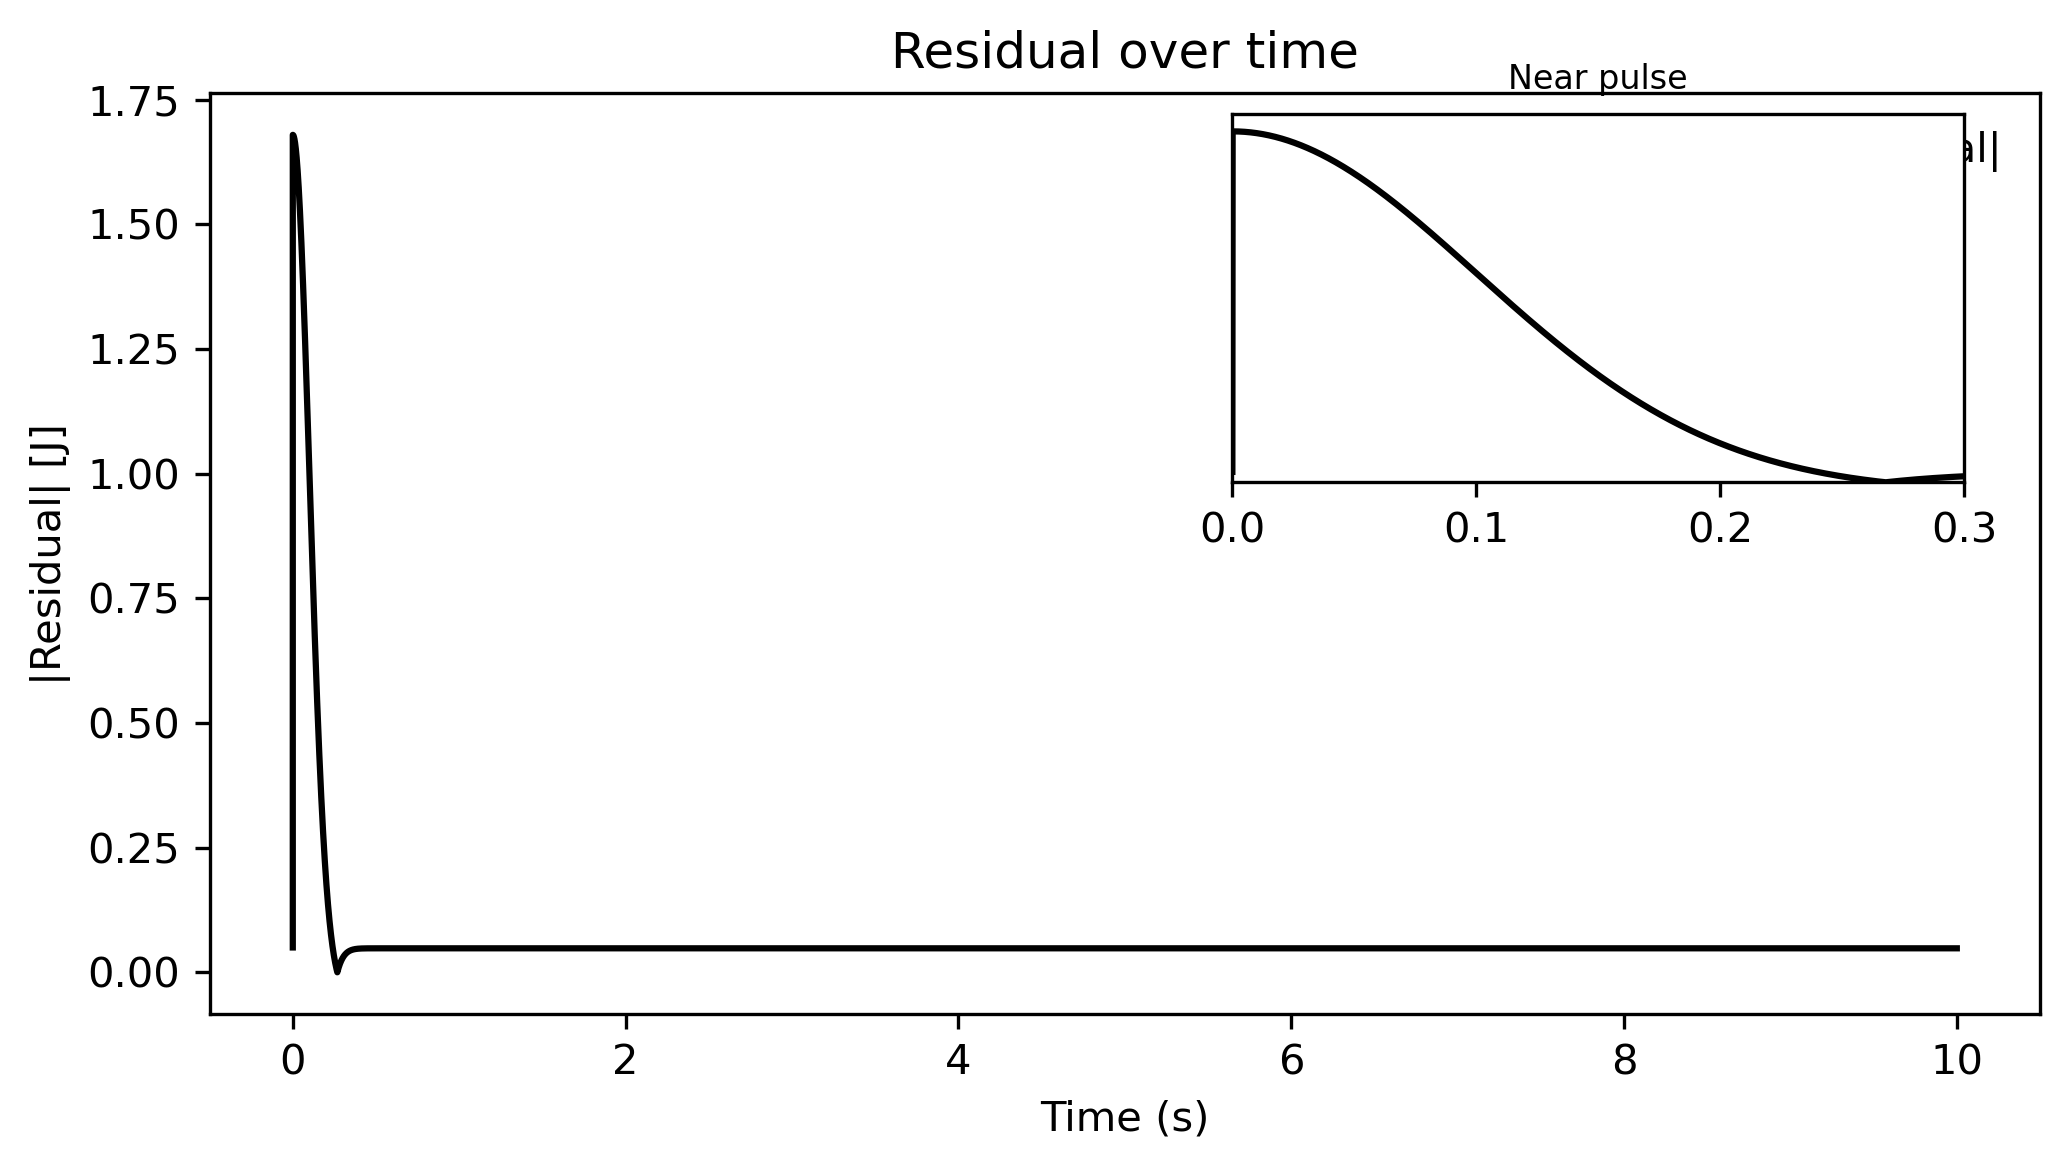

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

"""
Energy Residual Calculation and Visualization

This script computes and visualizes the energy residuals, the residuals
quantify the difference between the input energy, stored thermal
energy, and energy lost due to convection. 

Key Steps:
1. Define simulation parameters:
   - Input power (P), spatial discretization (dr_fn), time step (dt_fn)
   - Material properties (rho, c, alpha) and geometric parameters (volume, surface area)
   - Convection coefficient (h)

2. Compute energy contributions:
   - E_input: cumulative energy supplied by the heat source
   - E_stored: thermal energy stored in the first radial segment
   - E_loss: cumulative energy lost via convective heat transfer

3. Calculate the energy residual:
   - Residual = E_input - E_stored - E_loss
   - Absolute value is taken for plotting

4. Visualization:
   - Main plot: residual magnitude over time
   - Inset: zoomed view around the initial pulse (0 to 3*sigma)
   - Provides insight into the early-time behavior and energy balance

5. Output:
   - Save plots as PDF and high-resolution PNG
   - Display plot interactively

Dependencies:
- numpy
- matplotlib (including mpl_toolkits.axes_grid1.inset_locator for inset axes)

"""

P = 0.5 * np.ones(len(temp_fn))  # W
length = 0.01                    # m
step_number = 80
dr_fn = length / step_number     # m
sigma = 0.1                      # s
dt_fn = dr_fn**2 / (6 * alpha)   # s

# Geometry: first radial segment
r_mid = dr_fn / 2
volume_segment = 2 * np.pi * r_mid * dr_fn * length
A = 2 * np.pi * r_mid * length   # side area for convection
h = 10                           # W/(m²·K), example

E_input = np.zeros(len(temp_fn))
E_input[0] = P[0] * sigma
E_input = np.cumsum(E_input)

E_stored = rho * c * volume_segment * (temp_fn - 293)  # J
E_loss = np.cumsum(h * A * (temp_fn - 293) * dt_fn)    # J

Residual = E_input - E_loss - E_stored

# --- Main plot ---
plt.rcParams.update({'figure.figsize': (7, 4), 'figure.dpi': 300})

fig, ax = plt.subplots()
ax.plot(time_fn, np.abs(Residual), color='k', label='|Residual|')
ax.set_xlabel('Time (s)')
ax.set_ylabel('|Residual| [J]')
ax.set_title('Residual over time')
ax.legend(frameon=False)
ax.grid(False)

axins = inset_axes(
    ax, 
    width="40%", 
    height="40%", 
    loc='upper right', 
    bbox_to_anchor=(-0.03, 0, 1, 1),  # shift as needed
    bbox_transform=ax.transAxes
)
axins.plot(time_fn, np.abs(Residual), color='k')
axins.set_xlim(0, sigma * 3)
axins.set_ylim(0, max(np.abs(Residual[(time_fn <= sigma * 3)])) * 1.05)
axins.set_xticks([0, 0.1, 0.2, 0.3])
axins.set_yticks([])
axins.set_title('Near pulse', fontsize=8)
axins.grid(False)
# <-- END INSET -->

# --- Save / show ---
fig.tight_layout()
fig.savefig('residual_with_inset.pdf', format='pdf', bbox_inches='tight')
fig.savefig('residual_with_inset.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

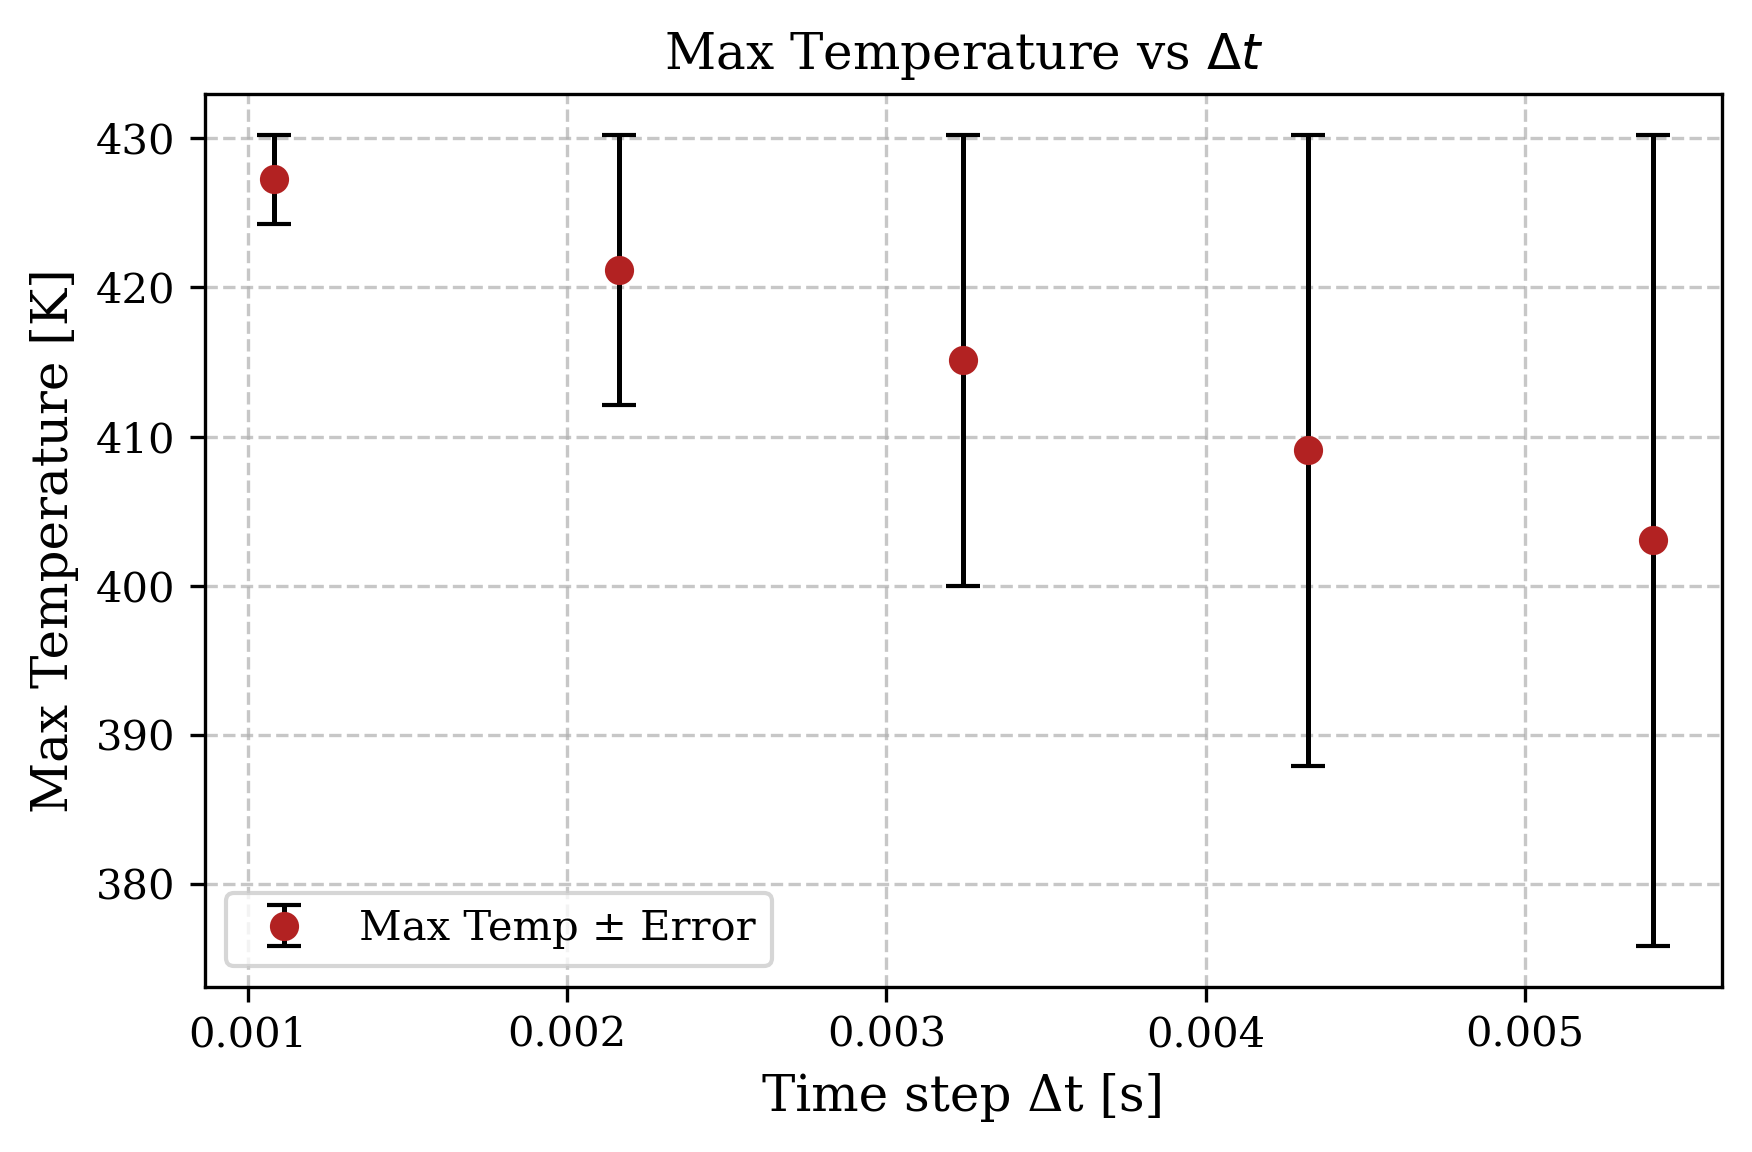

In [57]:
"""
Plotting Maximum Temperature vs. Time-Step with Error Bars

This script visualizes the effect of time-step size (Δt) on the 
maximum temperature predicted in a simulation, including associated 
absolute errors.

Key Steps:
1. Define data:
   - dt: list of time-step values used in the simulations
   - max_temp: corresponding maximum temperatures for each dt
   - max_abs_error: absolute error associated with each maximum temperature

2. Set up figure:
   - Adjust figure size for journal column or presentation
   - Configure error bars with marker size, color, cap size, and line width

3. Configure axes:
   - Label x-axis (dt [s]) and y-axis (Max Temperature [K])
   - Set title
   - Adjust tick font sizes for clarity
   - Optionally, use log scale for x-axis if needed

4. Styling:
   - Add grid with dashed lines and transparency
   - Add legend for clarity
   - Apply tight layout to avoid clipping

5. Save figure:
   - High-resolution PNG for raster use
   - PDF vector format for journal submission

6. Display figure:
   - Interactive display for immediate visualization

Notes:
- This plot assess **time-step sensitivity** and the 
  **numerical stability** of the simulation.
- Error bars indicate the variability in the 
  maximum temperature measurement.
- Provides guidance for selecting an appropriate dt for future simulations.

Dependencies:
- matplotlib
"""



import matplotlib.pyplot as plt

# Data (Taken from data set)
dt = [1.08033232E-03, 2.16066465E-03, 3.24099697E-03, 4.32132930E-03, 5.40166162E-03]
max_temp = [427.227020, 421.160156, 415.115448, 409.076782, 403.040894]
max_abs_error = [3.00720215, 9.07406616, 15.1187744, 21.1574402, 27.1933289]

# Figure settings
plt.figure(figsize=(6,4))  # Smaller for journal column
plt.errorbar(dt, max_temp, yerr=max_abs_error, fmt='o', 
             color='firebrick', ecolor='black', elinewidth=1.2, capsize=4, markersize=6, label='Max Temp ± Error')

# Axis labels with units
plt.xlabel('Time step Δt [s]', fontsize=12)
plt.ylabel('Max Temperature [K]', fontsize=12)
plt.title('Max Temperature vs $\Delta t$', fontsize = 12)
# Tick parameters
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Optional log scale if journal prefers clarity
# plt.xscale('log')

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Save high-res versions for journal submission
plt.savefig('max_temp_vs_dt_error.pdf')  # vector format preferred
plt.savefig('max_temp_vs_dt_error.png', dpi=300)  # high-res raster backup

plt.show()


Estimated convergence rate (filtered) p = 1.498
Estimated R^2 (filtered) = 0.689


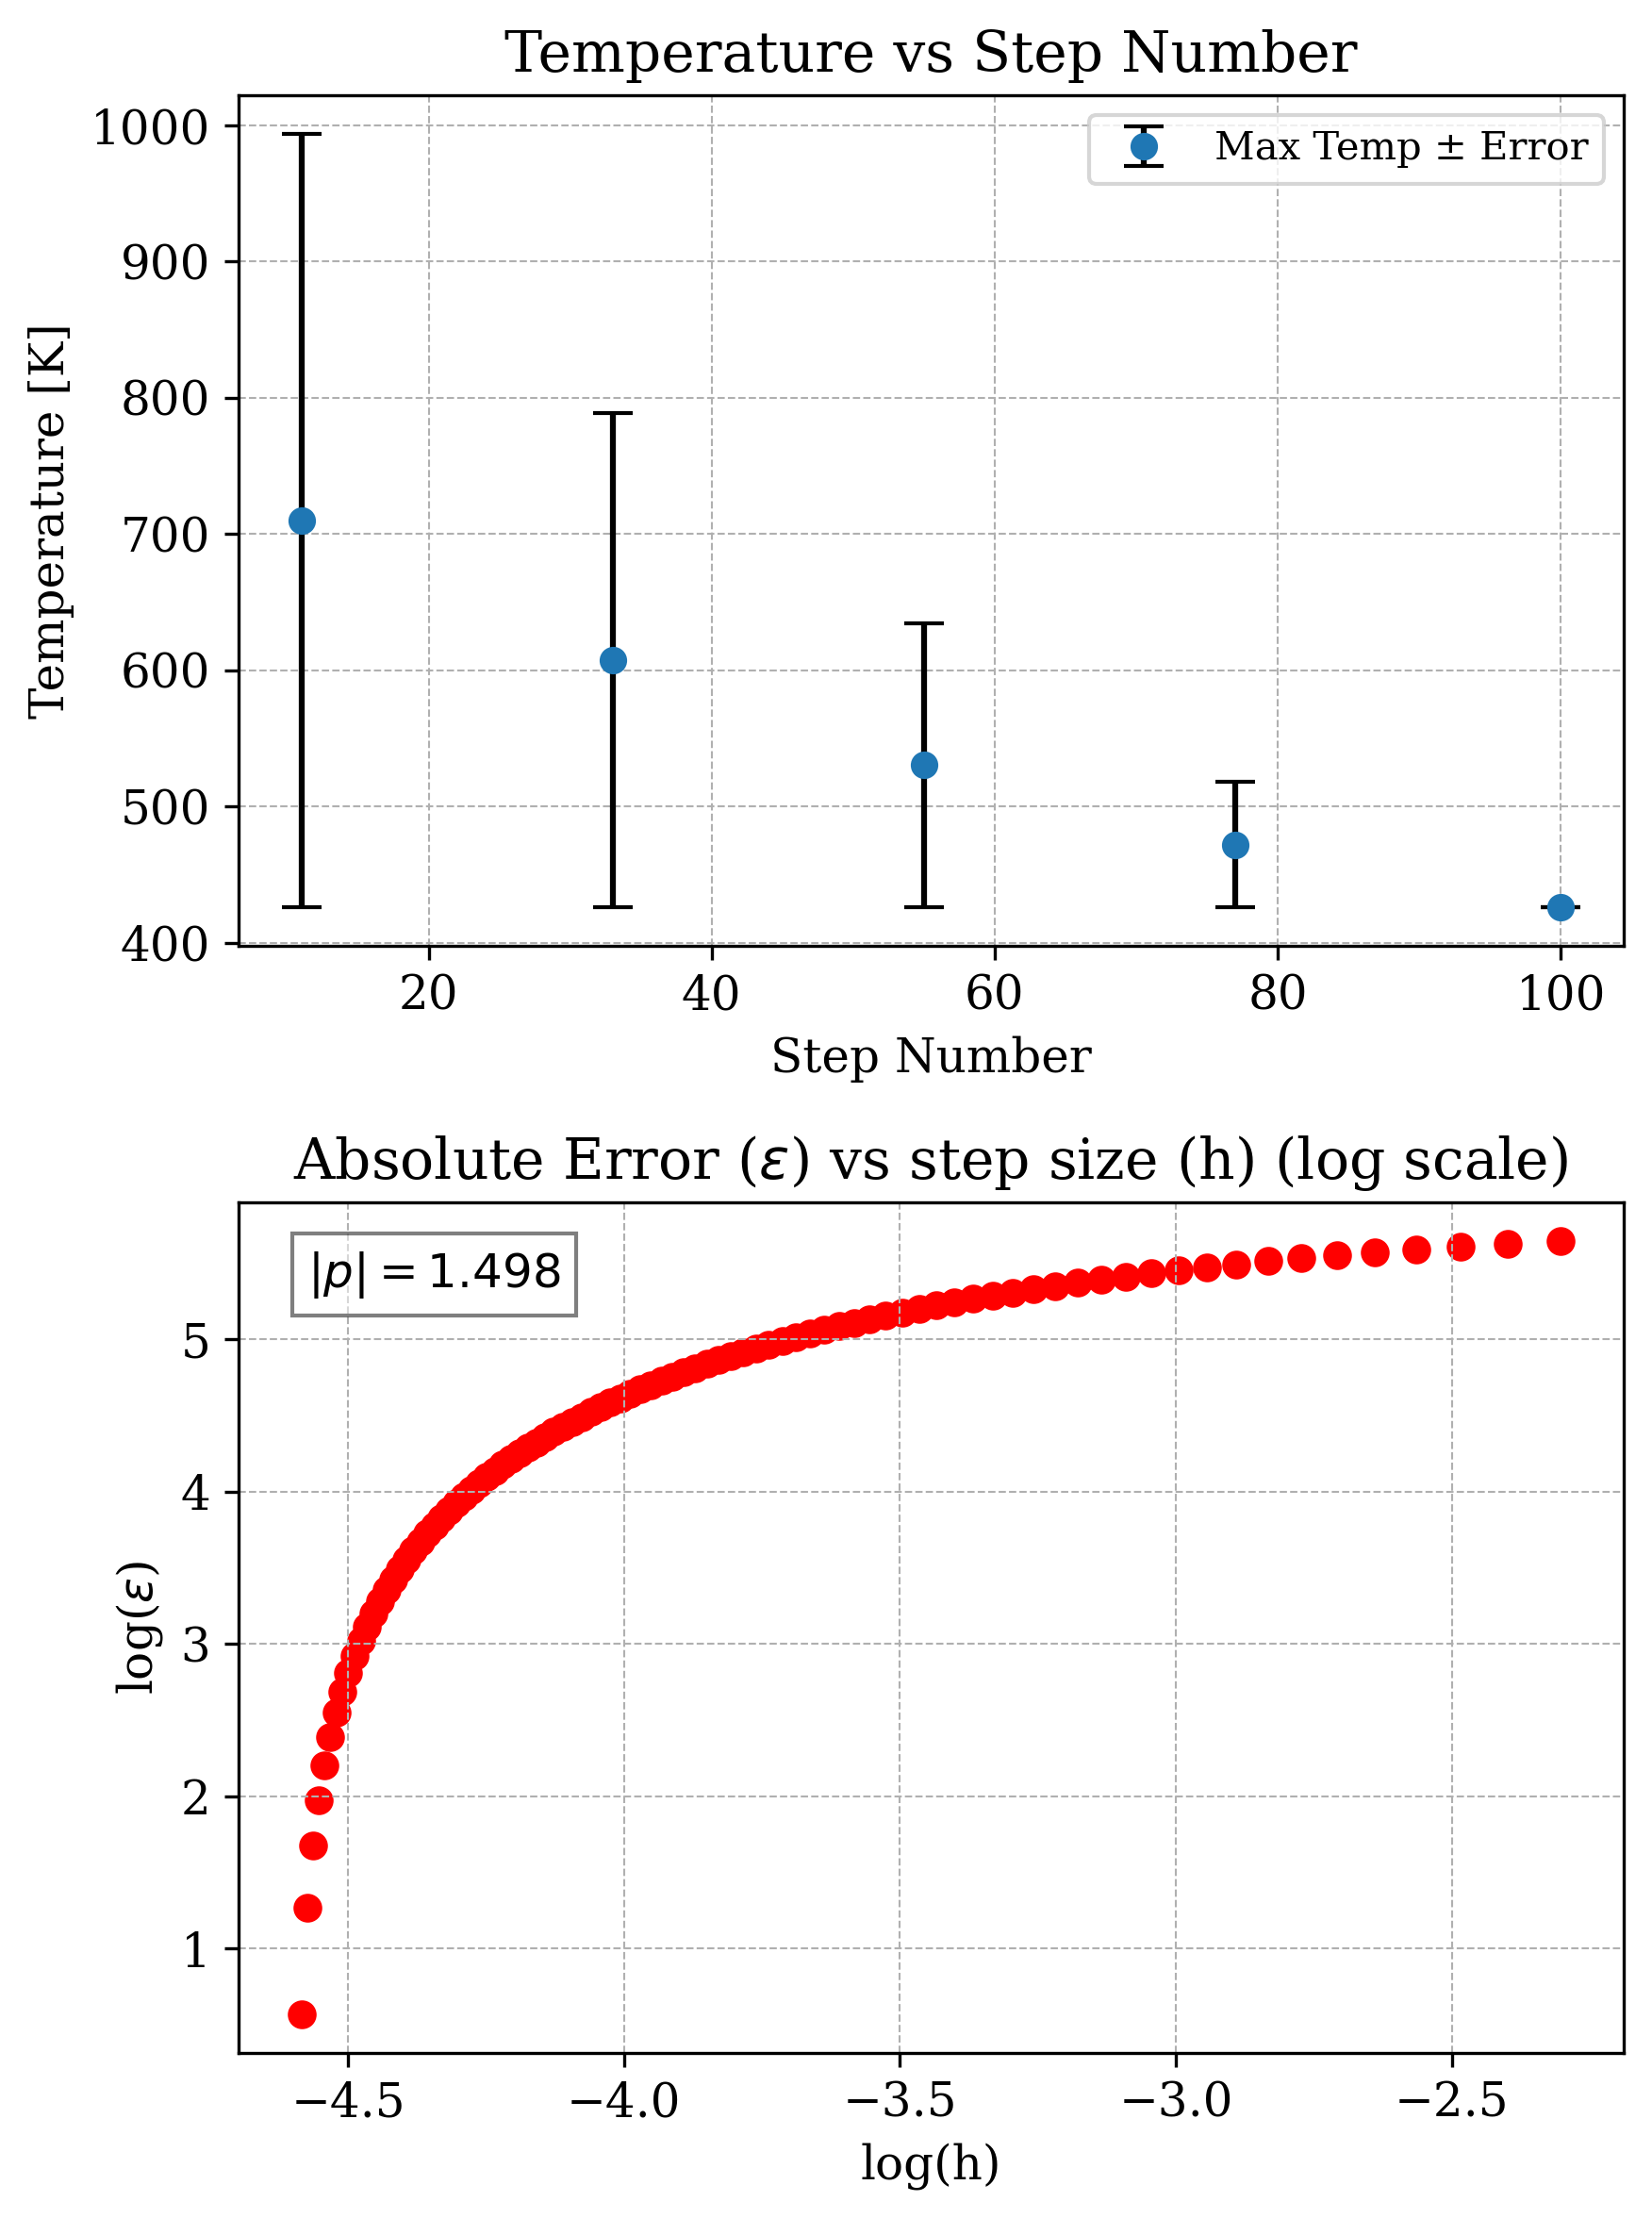

In [10]:
"""
Grid Convergence Analysis and Visualization

This script analyzes the convergence behavior of a numerical simulation 
by examining how the absolute error of the maximum temperature depends 
on the spatial discretization (step number or step size).

Key Steps:
1. Load simulation data:
   - step numbers, absolute errors, and maximum temperatures

2. Top plot:
   - Select 5 representative points from the dataset
   - Plot maximum temperature vs. step number with error bars
   - Provides a clear overview of how temperature and error vary with grid resolution

3. Bottom plot:
   - Filter data for step numbers ≤ 99
   - Convert step number to spatial step size (h = L / (N-1))
   - Plot absolute error vs. h on a log-log scale
   - Perform a linear fit in log-log space to estimate the convergence rate (slope)
   - Compute R² to assess goodness of fit
   - Annotate plot with estimated convergence rate

4. Figure formatting:
   - Configure fonts, grid lines, labels, titles, and markers
   - Save figure as high-resolution PNG

Notes:
- The slope of the log-log plot indicates the **numerical order of convergence**.
- This analysis helps assess whether the numerical method behaves as expected
  when refining the grid.
- Top plot gives intuitive understanding; bottom plot quantifies convergence.

Dependencies:
- numpy
- matplotlib
"""





import numpy as np
import matplotlib.pyplot as plt

# --- Import data ---
data_steps = np.loadtxt('abs_error_vs_step_number.txt')
steps_num = data_steps[:, 0]
temp_steps = data_steps[:, 2]
abs_error_steps = data_steps[:, 1]

# --- Top plot: subset of 5 points ---
indices = np.linspace(0, len(steps_num)-1, 5, dtype=int)
steps_subset = steps_num[indices]
temp_subset = temp_steps[indices]
error_subset = abs_error_steps[indices]

# Table data for top/bottom plot
table_steps = ["12", "29", "46", "63", "80"]
table_error = ["320", "207", "134", "81", "39"]

# --- Filter data for bottom plot (step_num <= 99) ---
mask = steps_num <= 99
steps_num_filtered = steps_num[mask]
abs_error_filtered = abs_error_steps[mask]

# Compute actual step size h
L = 1.0  # replace with your domain length if different
h_filtered = L / (steps_num_filtered - 1)

# --- Figure setup ---
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# --- Top subplot ---
ax1.errorbar(
    steps_subset, temp_subset, yerr=error_subset, fmt='o', ecolor='black',
    capsize=5, markersize=6, elinewidth=1.5, label="Max Temp ± Error"
)
ax1.set_xlabel('Step Number')
ax1.set_ylabel('Temperature [K]')
ax1.set_title('Temperature vs Step Number')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.legend(loc='upper right', fontsize=10)

# --- Bottom subplot: log-log plot using h ---
ln_h = np.log(h_filtered)
ln_error = np.log(abs_error_filtered)

ax2.scatter(ln_h, ln_error, color='red', s=40, label='Abs Error')
ax2.set_xlabel('log(h)')
ax2.set_ylabel('log($\epsilon$)')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)


# --- Linear fit in log-log space ---
p, c = np.polyfit(ln_h, ln_error, 1)
pred = p * ln_h + c

# R^2 calculation
ss_res = np.sum((ln_error - pred)**2)
ss_tot = np.sum((ln_error - np.mean(ln_error))**2)
r2_filtered = 1 - ss_res / ss_tot

print(f"Estimated convergence rate (filtered) p = {p:.3f}")
print(f"Estimated R^2 (filtered) = {r2_filtered:.3f}")

# --- Add text box in axes coordinates ---
ax2.text(0.05, 0.9, f'$|p| = {p:.3f}$',
         transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax2.set_title('Absolute Error ($\epsilon$) vs step size (h) (log scale)')

plt.tight_layout()
plt.savefig('Grid_Convergence.png')
plt.show()
